#Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Challenge2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1LRDqoHBsKCFWi3z-Hv1rH_faI3hVcyc4/Challenge2


#Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

2.15.0


#Load data

stratified data available here: https://drive.google.com/drive/folders/1R-eabRhp69XpywrzMvB9c68qCFbvVKru?usp=sharing

##unzip data

In [ ]:
import zipfile
unzip=False
if unzip:
  extracted_dir = 'training_dataset'
  with zipfile.ZipFile('training_dataset.zip', 'r') as zip_ref:
      zip_ref.extractall(extracted_dir)
  print(f"Successfully extracted contents to {extracted_dir}")

##load

In [ ]:
%cd /gdrive/My Drive/[2023-2024] AN2DL/Challenge2/training_dataset

/gdrive/.shortcut-targets-by-id/1LRDqoHBsKCFWi3z-Hv1rH_faI3hVcyc4/Challenge2/training_dataset


In [ ]:
categories=np.load('categories.npy')

In [ ]:
valid_periods=np.load('valid_periods.npy')

In [ ]:
training_data=np.load('training_data.npy')

# TRAIN AND TEST SPLITTING


In [ ]:
data_train = np.load('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge2/DATA_STRATIFIED/X_train.npy',allow_pickle=True)
data_val = np.load('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge2/DATA_STRATIFIED/X_val.npy',allow_pickle=True)
data_test = np.load('/gdrive/MyDrive/[2023-2024] AN2DL/Challenge2/DATA_STRATIFIED/X_test.npy',allow_pickle=True)
print(data_train.shape, data_val.shape,data_test.shape)

(33596,) (7198,) (6,)


#Preprocessing

In [ ]:
def build_sequences(training_data, window, stride, telescope):
    dataset = [0]*training_data.shape[0]
    labels = [0]*training_data.shape[0]
    for i in range(training_data.shape[0]): #48.000 signals
      #vediamo la lunghezza di ciascuno e in base a questa andiamo ad aggiustare il padding quanto serve
      assert window % stride == 0
      temp_df = training_data[i].copy()
      temp_label = training_data[i].copy() #target is the signal itself
      padding_check = len(training_data[i])%window

      if(padding_check != 0):
          # Compute padding length
          padding_len = window - len(training_data[i])%window
          padding = np.zeros((padding_len), dtype='float32')
          temp_df = np.concatenate((padding,training_data[i])) # NEW SIGNAL AFTER PADDING
          temp_label = np.concatenate((padding,temp_label)) # NEW TARGET (= SIGNAL) AFTER PADDINNG
          assert len(temp_df) % window == 0

      temp_final_dataset = []
      tempp_final_lable = []
      for idx in np.arange(0,len(temp_df)-window-telescope,stride): # i want to save all the windows in the first position
          temp_final_dataset.append(temp_df[idx:idx+window])
          tempp_final_lable.append(temp_label[idx+window:idx+window+telescope])

      dataset[i] = np.array(temp_final_dataset)
      labels[i] = np.array(tempp_final_lable)

    return np.array(dataset), np.array(labels)

In [ ]:
def extract_window(X_train, y_train): #used to adjust the shape after using build_sequences
  X_train_final = []
  y_train_final = []
  for i in range(X_train.shape[0]):
    for ii in range(X_train[i].shape[0]):
      X_train_final.append(X_train[i][ii])
      y_train_final.append(y_train[i][ii])
  return np.array(X_train_final), np.array(y_train_final)


In [ ]:
def discard_padding(signal): #used to eliminate padding
  padding = True
  index = 0
  for i in range(signal.shape[0]):
    if signal[i] != 0:
      padding = False
      index = i
      break # as soon as we reach thhe
  valid_signal = signal[i:]

  return valid_signal

In [ ]:
def filter_window(X_t , y_t , thresh, filter_on_window=True):#used to eliminate windows with large padding
  if filter_on_window:
    X=[]
    y=[]
    for i in range(X_t.shape[0]):
      if not(np.count_nonzero(X_t[i] == 0)>(thresh)*X_t[0].shape[0]):
        X.append(X_t[i])
        y.append(y_t[i])
    X_t=np.array(X)
    y_t=np.array(y)
  return X_t, y_t

In [ ]:
def add_flipped_signal(signal): # used to substitute remaining zero padding with part of the flipped signal. It works on a single signal
  valid_signal = discard_padding(signal)
  diff = signal.shape[0] - valid_signal.shape[0]
  temp = [0]*diff
  for i in range(diff):
    temp[diff-1-i] = valid_signal[i+1]

  final_signal = np.concatenate([temp,valid_signal])

  return final_signal

In [ ]:
def sostitute_padding(X): # it calls add_flipped_signal in all the windows
  final = [0]*X.shape[0]
  for i in range(X.shape[0]):
    final[i] = add_flipped_signal(X[i])
  return np.array(final)

In [ ]:
def process_data(valid_signal,window = 50,stride = 10,telescope = 18): # calls all the previous functions
  #create window
  X,y = build_sequences(valid_signal, window, stride, telescope)
  X,y = extract_window(X, y)
  #eliminate large padding
  X , y = filter_window(X, y, thresh=0.4)
  #sostitute remaining padding with flipped signal
  X=sostitute_padding(X)
  return np.array(X),np.array(y)

In [ ]:
def compute_fft(X_test):
  X_fft_test=[]
  window=50
  for i in range(X_test.shape[0]):
    X_fft_test.append(np.fft.fft(X_test[i]-np.mean(X_test[i])))
  X_fft_test=np.array(X_fft_test)
  freqs = np.linspace(0,1,window) #frequencies go from 0 to
  X_fft_test=X_fft_test[:,:1+window//2]
  return X_fft_test

#Apply preprocessing

In [ ]:
X_train,y_train=process_data(data_train)
X_train_fft=compute_fft(X_train)

X_val,y_val=process_data(data_val)
X_val_fft=compute_fft(X_val)

X_test=[]
for i in range(6):
  for j in range(len(data_test[i])):
    X_test.append(data_test[i][j])
X_test=np.array(X_test)

X_test,y_test=process_data(X_test)
X_test_fft=compute_fft(X_test)

#Log1p(1-X) Transformation

In [ ]:
apply_transformation=False
if apply_transformation:
  X_train=np.log1p(1-X_train)
  y_train=np.log1p(1-y_train)

  X_val=np.log1p(1-X_val)
  y_val=np.log1p(1-y_val)

# MODEL ARCHITECTURE

In [ ]:
#we keep the same hyperparameters in order to compare different architecture
window=50
telescope=18
stride=10
input_shape = [window,1] # we can't use the standard procedure X_train.shape[2] since we have different lengths
output_shape = [telescope,1]
batch_size = 64
epochs = 200
LR = 0.05
patience_ES = 10
patience_LR = 5
factor_LR = 0.5

input_shape2=[1+window//2,1]

In [ ]:
def build_model(input_shape1, input_shape2, output_shape, LR):

  # time model
  assert input_shape1[0] >= output_shape[0]
  input_layer1 = tfkl.Input(shape=input_shape1, name='input_layer1')
  x1 = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer1)
  x1 = tfkl.Conv1D(128, 3, padding='valid', activation='relu', name='conv1')(x1)
  x1=tfkl.MaxPool1D(2)(x1)
  x1 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x1)
  x1 = tfkl.Conv1D(128, 3, padding='same', activation='relu')(x1)


  #frequency model
  input_layer2 = tfkl.Input(shape=input_shape2, name='input_layer2')
  x2 = tfkl.Conv1D(filters=32, kernel_size=3,padding='same')(input_layer2)
  x2 = tfkl.Activation('relu')(x2)
  x2 = tfkl.Conv1D(filters = 64, kernel_size=3,padding='same')(x2)
  x2 = tfkl.Activation('relu')(x2)
  x2 = tfkl.Conv1D(filters = 128, kernel_size=3,padding='valid')(x2)
  x2 = tfkl.Activation('relu')(x2)

  x2 = tfkl.Dropout(0.5)(x2)
  x2 = tfkl.Dense(128, activation='relu')(x2)
  x2 = tfkl.Dropout(0.5)(x2)
  x2 = tfkl.Dense(128, activation='relu')(x2)

  # concatenate the 2 outputa
  x = tf.concat([x1,x2],axis=-1)

 # x = tfkl.Dense(128, activation='linear')(x)

  x = tfkl.Dense(1, activation='linear')(x)  # Output with 1 unit

  crop_size = x.shape[1] - output_shape[0]
  output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(x)

  model = tf.keras.Model(inputs=[input_layer1,input_layer2], outputs=output_layer, name='CONV_LSTM_model')
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(LR), metrics = tf.keras.metrics.MeanAbsoluteError())

  return model

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer2 (InputLayer)   [(None, 26, 1)]              0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 26, 32)               128       ['input_layer2[0][0]']        
                                                                                                  
 activation (Activation)     (None, 26, 32)               0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 26, 64)               6208      ['activation[0][0]']          
                                                                                    

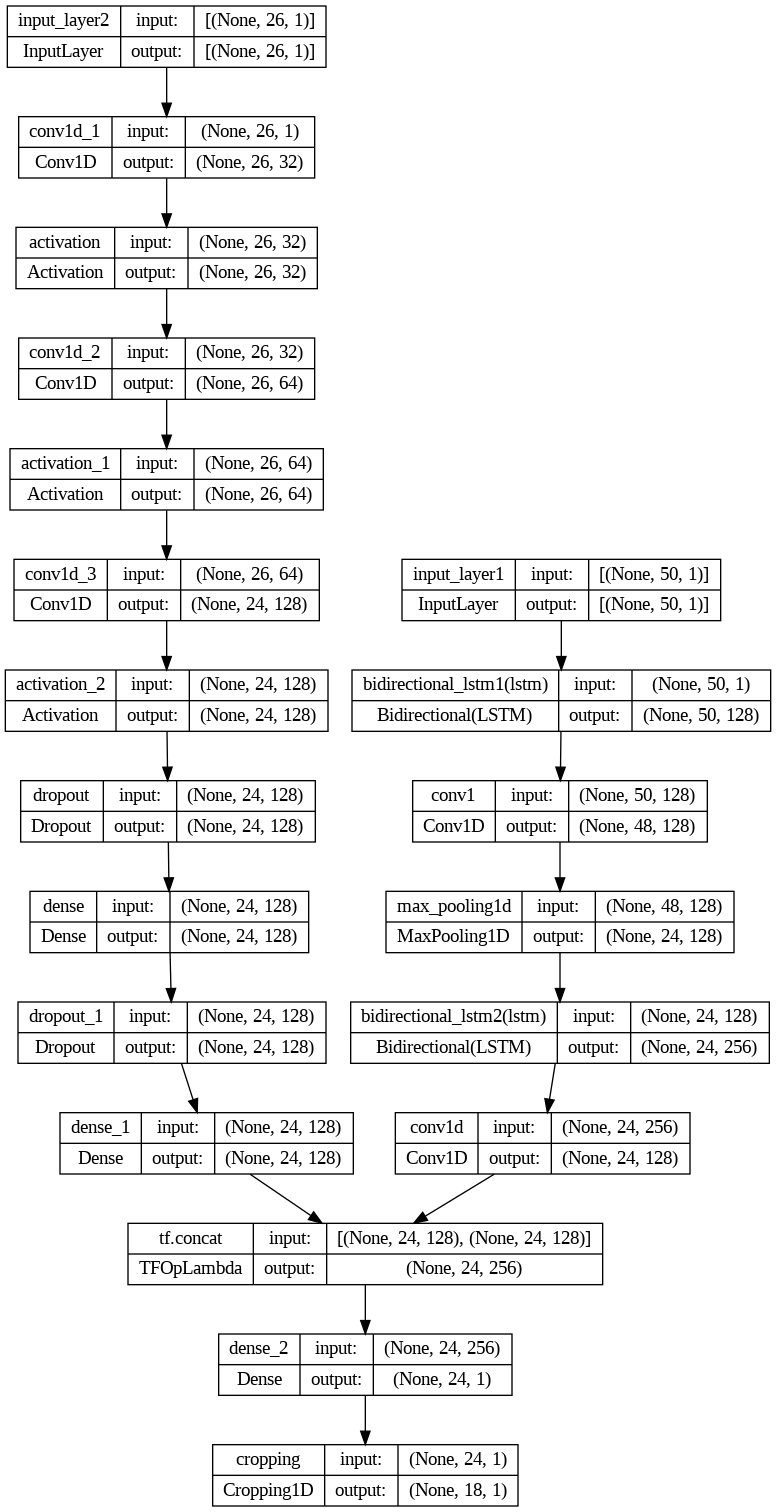

In [ ]:
model = build_model(input_shape, input_shape2,output_shape, LR)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x =[X_train,X_train_fft],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=([X_val,X_val_fft],y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience_ES, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=patience_LR, factor=factor_LR, min_lr=1e-5)
    ]
).history

Epoch 1/200
8001/8001 [==============================] - 169s 19ms/step - loss: 0.0157 - mean_absolute_error: 0.0863 - val_loss: 0.0135 - val_mean_absolute_error: 0.0793 - lr: 0.0100
Epoch 2/200
8001/8001 [==============================] - 146s 18ms/step - loss: 0.0127 - mean_absolute_error: 0.0766 - val_loss: 0.0125 - val_mean_absolute_error: 0.0762 - lr: 0.0100
Epoch 3/200
8001/8001 [==============================] - 147s 18ms/step - loss: 0.0119 - mean_absolute_error: 0.0737 - val_loss: 0.0120 - val_mean_absolute_error: 0.0732 - lr: 0.0100
Epoch 4/200
8001/8001 [==============================] - 146s 18ms/step - loss: 0.0117 - mean_absolute_error: 0.0725 - val_loss: 0.0119 - val_mean_absolute_error: 0.0717 - lr: 0.0100
Epoch 5/200
8001/8001 [==============================] - 151s 19ms/step - loss: 0.0115 - mean_absolute_error: 0.0717 - val_loss: 0.0120 - val_mean_absolute_error: 0.0751 - lr: 0.0100
Epoch 6/200
8001/8001 [==============================] - 140s 18ms/step - loss: 0.011

## SAVE


In [ ]:
from datetime import datetime
from dateutil.tz import gettz
import os

In [ ]:
WD_PATH = '/gdrive/MyDrive/[2023-2024] AN2DL/Challenge2/SALVATAGGI'
training_path = os.path.join(WD_PATH, 'Training_' + datetime.now(gettz("Europe/Rome")).strftime("%Y-%m-%d-T%H:%M"))
os.mkdir(training_path)

In [ ]:
def myprint(s):
    with open(training_path + '/modelsummary.txt','a') as f:
        print(s, file=f)
model.summary(print_fn=myprint)

In [ ]:
import pickle
file_path = training_path +'/model_history.pkl'

# Save the dictionary to a pickle file
with open(file_path, 'wb') as pickle_file:
    pickle.dump(history, pickle_file)

In [ ]:
model.save(training_path +'/model')

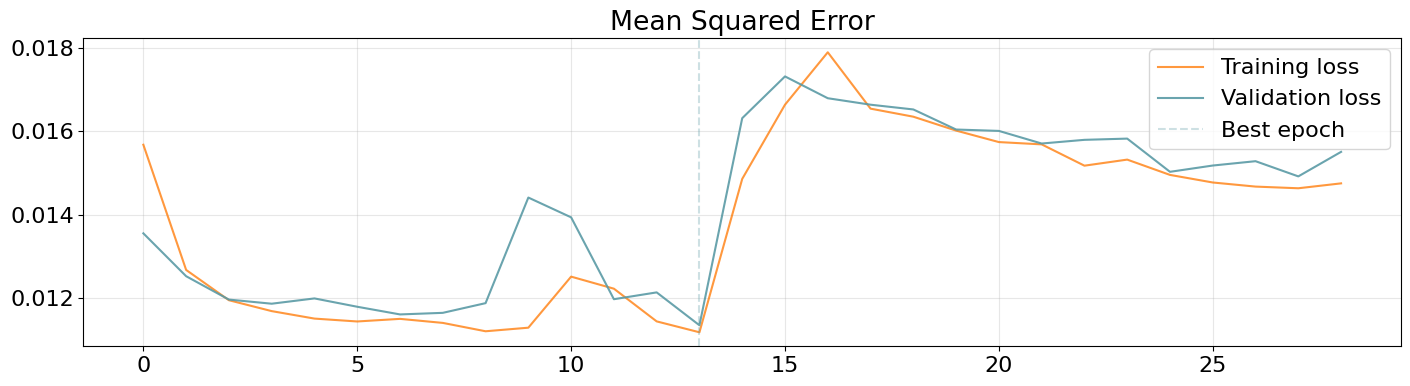

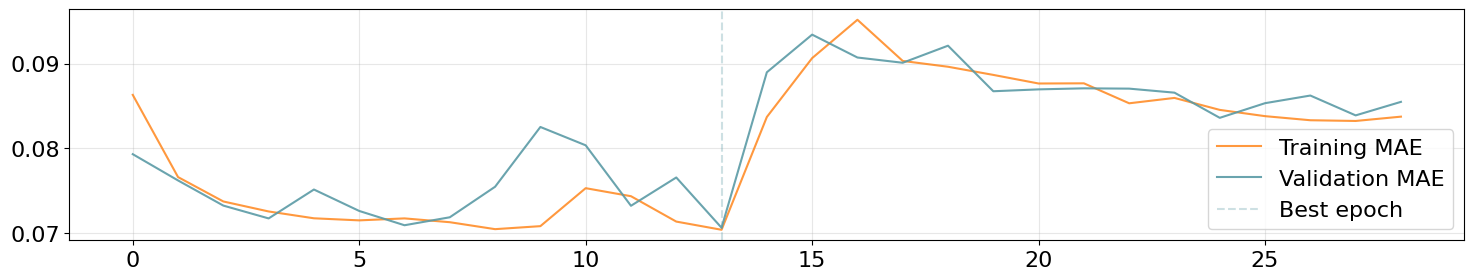

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.savefig(training_path +'/loss.png')
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mean_absolute_error'], label='Training MAE', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mean_absolute_error'], label='Validation MAE', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.savefig(training_path +'/MAE.png')
plt.show()

#Results

In [ ]:
if apply_transformation:
  X_test=np.log1p(1-X_test)

In [ ]:
predictions = model.predict([X_test,X_test_fft],verbose=0)
if apply_transformation:
  predictions=2-np.exp(predictions)
  mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error: {mean_squared_error}")
  mean_absolute_error = mean_absolute_error(y_test.flatten(), (predictions.flatten()))
  print(f"Mean Absolute Error: {mean_absolute_error}")

else:
  mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error: {mean_squared_error}")
  mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
  print(f"Mean Absolute Error: {mean_absolute_error}")

Mean Squared Error: 0.011040638200938702
Mean Absolute Error: 0.06937108933925629
